## 1) Import libraries and load data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import cPickle as pickle
DATA_PATH = 'merged.pickle'

np.random.seed(42)

import tensorflow as tf
gpu_options = tf.GPUOptions(allow_growth=True,per_process_gpu_memory_fraction=0.333)
s = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))
import keras

Using TensorFlow backend.


In [2]:
with open(DATA_PATH, 'r') as f:
    data = pickle.load(f)

labels = np.load('labels.npy')

## 2) Preprocessing steps with data & features

In [3]:
# features which we want to delete
not_features = [
    '_luminosityBlock',
    '_run',
    '_instantLumi_minibias',
    '_instantLumi_muons',
    '_instantLumi_photons'
]

# columns that correspond to actual features
features = sorted(set(data.columns) - set(not_features))

In [4]:
# features normalization
for f in features:
    xs = data[f].values

    if np.std(xs) > 0.0:
        data[f] = (xs - np.mean(xs)) / np.std(xs)

In [5]:
lumi = np.maximum(
    np.maximum(data['_instantLumi_minibias'].get_values(), 
               data['_instantLumi_muons'].get_values()),
               data['_instantLumi_photons'].get_values()
)

nonempty = np.where(lumi > 0.0)[0]

In [6]:
data = data.iloc[nonempty]
lumi = lumi[nonempty]
labels = labels[nonempty]

In [7]:
del data['_luminosityBlock']
del data['_run']
del data['_instantLumi_minibias']
del data['_instantLumi_muons']
del data['_instantLumi_photons']

In [8]:
data['labels'] = pd.Series(labels, index=data.index)

In [9]:
data

,minibias_PF_Px_mean,minibias_PF_Px_p1,minibias_PF_Px_p25,minibias_PF_Px_p50,minibias_PF_Px_p75,minibias_PF_Px_p99,minibias_PF_Px_std,minibias_PF_Py_mean,minibias_PF_Py_p1,minibias_PF_Py_p25,...,photons_photons_pt__q4_p99,photons_photons_pt__q4_std,photons_photons_pt__q5_mean,photons_photons_pt__q5_p1,photons_photons_pt__q5_p25,photons_photons_pt__q5_p50,photons_photons_pt__q5_p75,photons_photons_pt__q5_p99,photons_photons_pt__q5_std,labels
0,0.553982,0.121924,-2.377744,2.979489,3.999278,0.334869,-0.185235,-0.141756,-0.041391,-3.517199,...,0.771053,0.613178,0.671934,-0.115348,0.529921,0.626325,0.669504,0.781640,0.624168,0.0
1,0.618719,0.140093,-2.245878,3.164899,4.423358,0.350631,-0.162238,-0.141120,-0.119621,-3.520591,...,1.448301,0.720708,0.596897,-0.115348,0.500126,0.613411,0.762044,0.373972,0.564393,0.0
2,0.590468,0.089144,-2.267943,3.180846,4.379818,0.322018,-0.174552,-0.094414,-0.091330,-3.533495,...,0.315584,0.565043,0.521407,-0.115348,0.398654,0.593673,0.525674,1.095464,0.607292,0.0
3,0.563941,0.119073,-2.135948,3.271239,4.200118,0.282537,-0.179577,-0.155060,-0.146141,-3.579560,...,1.116072,0.778321,0.669518,-0.115348,0.659620,0.662089,0.603566,0.905891,0.494840,0.0
4,0.512639,0.077763,-2.699199,2.974805,4.191212,0.289252,-0.170892,-0.122369,-0.076968,-3.478975,...,0.397704,0.620604,0.533768,-0.115348,0.444284,0.585253,0.609742,1.004260,0.574727,0.0
5,0.517615,0.103767,-2.663293,2.657162,3.985256,0.322439,-0.181862,-0.197882,-0.154620,-3.705487,...,1.369331,0.777599,0.577041,-0.115348,0.526261,0.596193,0.478365,0.648295,0.346964,0.0
6,0.563187,0.102591,-2.438237,2.993670,4.275795,0.295974,-0.166590,-0.109062,-0.073422,-3.290235,...,0.240982,0.398985,0.444162,-0.115348,0.329574,0.505470,0.449276,0.451287,0.421262,0.0
7,0.505455,0.100209,-2.434321,3.207387,3.973735,0.348104,-0.085094,-0.167685,-0.142384,-3.601714,...,0.244517,0.423203,0.507372,-0.115348,0.346889,0.567593,0.525296,0.685222,0.375095,0.0
8,0.574270,0.096662,-1.984827,3.611923,4.527441,0.280905,-0.184592,-0.136945,-0.170748,-3.444420,...,0.125781,0.404884,0.529739,-0.115348,0.443858,0.608706,0.572331,0.111104,0.021400,0.0
9,0.143227,0.193403,-1.220393,-0.248370,0.592133,-0.037007,-0.274584,-0.069520,-0.032653,0.067565,...,0.757568,0.771628,0.576278,-0.115348,0.400897,0.583197,0.597291,0.727995,0.536766,0.0


In [10]:
from sklearn.model_selection import train_test_split

df = np.array(data)

X_train, X_test = train_test_split(df, test_size=0.1)

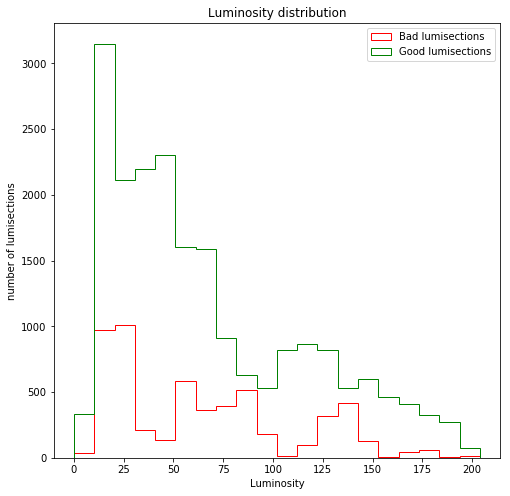

In [11]:
plt.figure(figsize=(8, 8))

plt.hist(
    [lumi[labels == 1.0], lumi[labels == 0.0]],
    label=['Good lumisections', 'Bad lumisections'],
    color=['green', 'red'],
    bins=20,
    histtype='step'
)

plt.legend(loc='upper right')

plt.title('Luminosity distribution')
plt.xlabel('Luminosity')
plt.ylabel('number of lumisections')
plt.show()

## 3) Build the network/autoencoder


In [12]:
from keras.models import Model
from keras.layers import Input, Dense
from keras.activations import relu
from keras.regularizers import l2
from keras.initializers import Orthogonal

In [ ]:
dense3 = Dense(
        512, activation=leaky_relu,
        kernel_regularizer=l2(regularization_coef),
        kernel_initializer=Orthogonal(),
    )(dense2)


dedense1 = Dense(
        512, activation=leaky_relu,
        kernel_regularizer=l2(regularization_coef),
        kernel_initializer=Orthogonal(),
    )(encoded)

In [13]:
def make_autoencoder():
    leaky_relu = lambda x: relu(x, alpha=0.05)
    regularization_coef = 1.0e-10
    
    inputs = Input(shape=(2695,))
    
    dense1 = Dense(
        2048, activation=leaky_relu,
        kernel_regularizer=l2(regularization_coef),
        kernel_initializer=Orthogonal(),
    )(inputs)
    
    dense2 = Dense(
        1024, activation=leaky_relu,
        kernel_regularizer=l2(regularization_coef),
        kernel_initializer=Orthogonal(),
    )(dense1)
    
    

    encoded = Dense(
        512, activation=leaky_relu,
        kernel_regularizer=l2(regularization_coef),
        kernel_initializer=Orthogonal(),
        name='encoded'
    )(dense2)
    
    
    
    dedense1 = Dense(
        1024, activation=leaky_relu,
        kernel_regularizer=l2(regularization_coef),
        kernel_initializer=Orthogonal(),
    )(encoded)
    
    dedense2 = Dense(
        2048, activation=leaky_relu,
        kernel_regularizer=l2(regularization_coef),
        kernel_initializer=Orthogonal(),
    )(dedense1)
    
    outputs = Dense(2695)(dedense2)
    
    return Model(inputs=inputs, outputs=outputs), Model(inputs=inputs, outputs=encoded)

In [14]:
ae, ae_encoder = make_autoencoder()

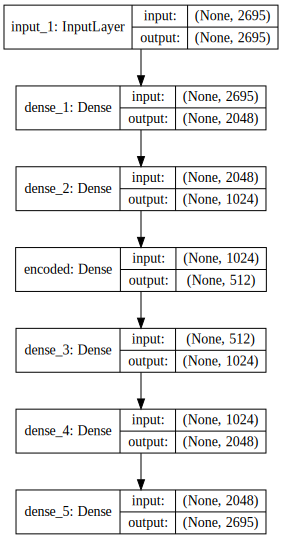

In [15]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(ae, show_shapes=True).create(prog='dot', format='svg'))

In [16]:
from keras.optimizers import Adadelta
from keras.objectives import MSE

In [17]:
ae.compile(optimizer=Adadelta(), loss=MSE)

In [18]:
ae.fit(X_train, X_train, epochs=12)

Epoch 1/12
23441/23441 [==============================] - 316s - loss: 0.2492      

In [19]:
X_pred = ae.predict(X_test)

In [20]:
print('Test MSE:', np.mean((X_pred - X_test) ** 2))

('Test MSE:', 0.15365607390234226)


## ROC-curve labels signals

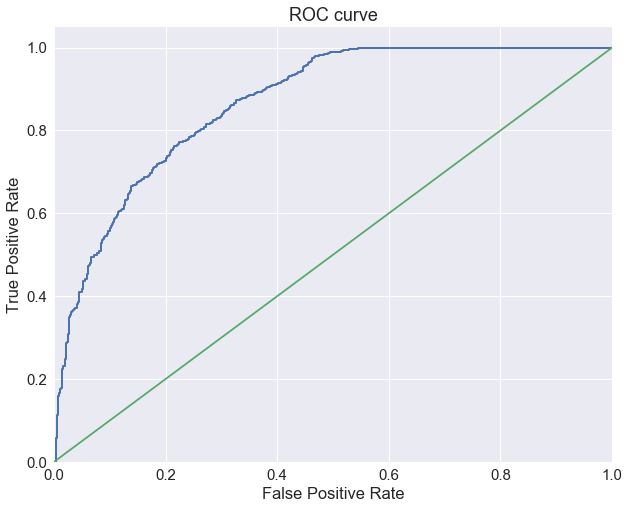

In [21]:
import seaborn as sns
from sklearn.metrics import roc_curve

sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
fpr, tpr, thresholds = roc_curve(X_test[:,-1], X_pred[:,-1], pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show()

### Optional
### Previous versions of networks

In [14]:
# For training, we want to sample examples at random in small batches
def batch_gen(X, y, N):
    while True:
        idx = np.random.choice(len(y), N)
        yield X[idx].astype('float32'), y[idx].astype('int32')

In [15]:
l_in = lasagne.layers.InputLayer((None, 2694))

l_hid1 = lasagne.layers.DenseLayer(l_in,
                                 num_units=1800,
                                 nonlinearity=lasagne.nonlinearities.rectify)

l_hid2 = lasagne.layers.DenseLayer(l_hid1,
                                 num_units=1000,
                                 nonlinearity=lasagne.nonlinearities.rectify)

l_hid3 = lasagne.layers.DenseLayer(l_hid2,
                                 num_units=400,
                                 nonlinearity=lasagne.nonlinearities.rectify)

l_hid4 = lasagne.layers.DenseLayer(l_hid3,
                                 num_units=1000,
                                 nonlinearity=lasagne.nonlinearities.rectify)

l_hid5 = lasagne.layers.DenseLayer(l_hid4,
                                 num_units=1800,
                                 nonlinearity=lasagne.nonlinearities.rectify)

l_out = lasagne.layers.DenseLayer(l_hid5,
                                 num_units=2694,
                                 nonlinearity=lasagne.nonlinearities.softmax)


In [16]:
X_sym = T.matrix()
y_sym = T.ivector()

# Theano expressions for the output distribution and predicted class
output = lasagne.layers.get_output(l_out, X_sym)
pred = output.argmax(-1)

# The loss function is cross-entropy averaged over a minibatch, we also compute accuracy
loss = T.mean(lasagne.objectives.categorical_crossentropy(output, y_sym))
acc = T.mean(T.eq(pred, y_sym))

params = lasagne.layers.get_all_params(l_out)
grad = T.grad(loss, params)
updates = lasagne.updates.sgd(grad, params, learning_rate=0.07)

f_train = theano.function([X_sym, y_sym], [loss, acc], updates=updates)
f_val = theano.function([X_sym, y_sym], [loss, acc])

BATCH_SIZE = 500
N_BATCHES = len(X_train) // BATCH_SIZE
N_VAL_BATCHES = len(X_val) // BATCH_SIZE

# Minibatch generators for the training and validation sets
train_batches = batch_gen(X_train, y_train, BATCH_SIZE)
val_batches = batch_gen(X_val, y_val, BATCH_SIZE)

In [17]:
test_curve = list()
train_curve = list()

for epoch in range(51):
    train_loss = 0
    train_acc = 0
    for _ in range(N_BATCHES):
        X, y = next(train_batches)
        loss, acc = f_train(X, y)
        train_loss += loss
        train_acc += acc
    train_loss /= N_BATCHES
    train_acc /= N_BATCHES
    train_curve.append(train_acc)
    
    val_loss = 0
    val_acc = 0
    for _ in range(N_VAL_BATCHES):
        X, y = next(val_batches)
        loss, acc = f_val(X, y)
        val_loss += loss
        val_acc += acc
    val_loss /= N_VAL_BATCHES
    val_acc /= N_VAL_BATCHES
    test_curve.append(val_acc)
    
    print('Epoch {}, Train (val) loss {:.03f} ({:.03f}) ratio {:.03f}'.format(
           epoch, train_loss, val_loss, val_loss/train_loss))
    print('Train (val) accuracy {:.03f} ({:.03f})'.format(train_acc, val_acc))

Epoch 0, Train (val) loss 1.984 (0.469) ratio 0.236
Train (val) accuracy 0.757 (0.823)
Epoch 1, Train (val) loss 0.420 (0.421) ratio 1.002
Train (val) accuracy 0.857 (0.855)
Epoch 2, Train (val) loss 0.374 (0.623) ratio 1.665
Train (val) accuracy 0.870 (0.834)
Epoch 3, Train (val) loss 0.335 (0.321) ratio 0.958
Train (val) accuracy 0.883 (0.880)
Epoch 4, Train (val) loss 0.328 (0.332) ratio 1.010
Train (val) accuracy 0.881 (0.874)
Epoch 5, Train (val) loss 0.307 (0.303) ratio 0.987
Train (val) accuracy 0.886 (0.890)
Epoch 6, Train (val) loss 0.301 (0.328) ratio 1.087
Train (val) accuracy 0.886 (0.893)
Epoch 7, Train (val) loss 0.284 (0.284) ratio 1.002
Train (val) accuracy 0.892 (0.881)
Epoch 8, Train (val) loss 0.271 (0.267) ratio 0.984
Train (val) accuracy 0.897 (0.892)
Epoch 9, Train (val) loss 0.254 (0.257) ratio 1.013
Train (val) accuracy 0.904 (0.894)
Epoch 10, Train (val) loss 0.252 (0.261) ratio 1.036
Train (val) accuracy 0.905 (0.896)
Epoch 11, Train (val) loss 0.249 (0.261) r

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


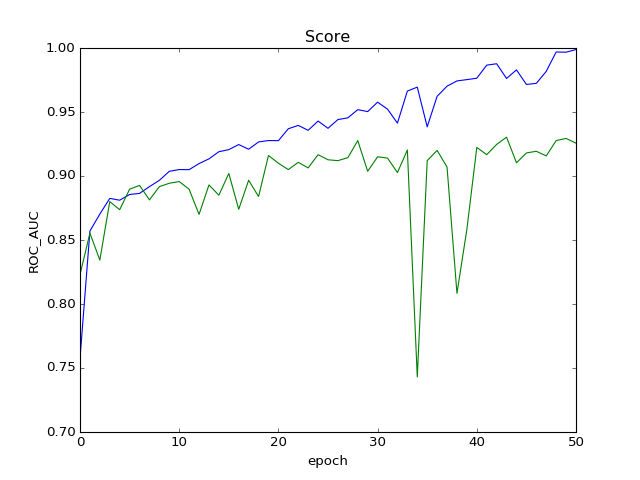

In [18]:
plt.title("Score")
plt.xlabel('epoch')
plt.ylabel('ROC_AUC')
plt.plot(train_curve)
plt.plot(test_curve)
plt.savefig('N4_600epoch.png')

## 3.2) Let's try Dropout

In [20]:
l_in = lasagne.layers.InputLayer((None, 2694))

l_hid1 = lasagne.layers.DenseLayer(l_in,
                                 num_units=1700,
                                 nonlinearity=lasagne.nonlinearities.rectify)

l_hid2 = lasagne.layers.DenseLayer(l_hid1,
                                 num_units=1000,
                                 nonlinearity=lasagne.nonlinearities.rectify)

l_hid3 = lasagne.layers.DropoutLayer(l_hid2,
                                 p = 0.5)

l_hid4 = lasagne.layers.DenseLayer(l_hid3,
                                 num_units=1000,
                                 nonlinearity=lasagne.nonlinearities.rectify)

l_hid5 = lasagne.layers.DenseLayer(l_hid4,
                                 num_units=1700,
                                 nonlinearity=lasagne.nonlinearities.rectify)

l_out = lasagne.layers.DenseLayer(l_hid5,
                                 num_units=2694,
                                 nonlinearity=lasagne.nonlinearities.softmax)

In [21]:
X_sym = T.matrix()
y_sym = T.ivector()

# Theano expressions for the output distribution and predicted class
output = lasagne.layers.get_output(l_out, X_sym)
pred = output.argmax(-1)

# The loss function is cross-entropy averaged over a minibatch, we also compute accuracy
loss = T.mean(lasagne.objectives.categorical_crossentropy(output, y_sym))
acc = T.mean(T.eq(pred, y_sym))

params = lasagne.layers.get_all_params(l_out)
grad = T.grad(loss, params)
updates = lasagne.updates.sgd(grad, params, learning_rate=0.07)

f_train = theano.function([X_sym, y_sym], [loss, acc], updates=updates)
f_val = theano.function([X_sym, y_sym], [loss, acc])

BATCH_SIZE = 500
N_BATCHES = len(X_train) // BATCH_SIZE
N_VAL_BATCHES = len(X_val) // BATCH_SIZE

# Minibatch generators for the training and validation sets
train_batches = batch_gen(X_train, y_train, BATCH_SIZE)
val_batches = batch_gen(X_val, y_val, BATCH_SIZE)

In [22]:
test_curve = list()
train_curve = list()

for epoch in range(41):
    train_loss = 0
    train_acc = 0
    for _ in range(N_BATCHES):
        X, y = next(train_batches)
        loss, acc = f_train(X, y)
        train_loss += loss
        train_acc += acc
    train_loss /= N_BATCHES
    train_acc /= N_BATCHES
    train_curve.append(train_acc)
    
    val_loss = 0
    val_acc = 0
    for _ in range(N_VAL_BATCHES):
        X, y = next(val_batches)
        loss, acc = f_val(X, y)
        val_loss += loss
        val_acc += acc
    val_loss /= N_VAL_BATCHES
    val_acc /= N_VAL_BATCHES
    test_curve.append(val_acc)
    
    print('Epoch {}, Train (val) loss {:.03f} ({:.03f}) ratio {:.03f}'.format(
           epoch, train_loss, val_loss, val_loss/train_loss))
    print('Train (val) accuracy {:.03f} ({:.03f})'.format(train_acc, val_acc))

Epoch 0, Train (val) loss 1.195 (0.431) ratio 0.361
Train (val) accuracy 0.783 (0.842)
Epoch 1, Train (val) loss 0.405 (0.492) ratio 1.216
Train (val) accuracy 0.858 (0.839)
Epoch 2, Train (val) loss 0.393 (0.338) ratio 0.860
Train (val) accuracy 0.865 (0.871)
Epoch 3, Train (val) loss 0.366 (0.345) ratio 0.944
Train (val) accuracy 0.868 (0.866)
Epoch 4, Train (val) loss 0.315 (0.292) ratio 0.928
Train (val) accuracy 0.883 (0.881)
Epoch 5, Train (val) loss 0.313 (0.305) ratio 0.974
Train (val) accuracy 0.882 (0.870)
Epoch 6, Train (val) loss 0.298 (0.292) ratio 0.980
Train (val) accuracy 0.881 (0.877)
Epoch 7, Train (val) loss 0.279 (0.355) ratio 1.273
Train (val) accuracy 0.892 (0.871)
Epoch 8, Train (val) loss 0.286 (0.273) ratio 0.954
Train (val) accuracy 0.888 (0.882)
Epoch 9, Train (val) loss 0.278 (0.299) ratio 1.075
Train (val) accuracy 0.892 (0.878)
Epoch 10, Train (val) loss 0.252 (0.279) ratio 1.105
Train (val) accuracy 0.902 (0.889)
Epoch 11, Train (val) loss 0.259 (0.294) r

<IPython.core.display.Javascript object>


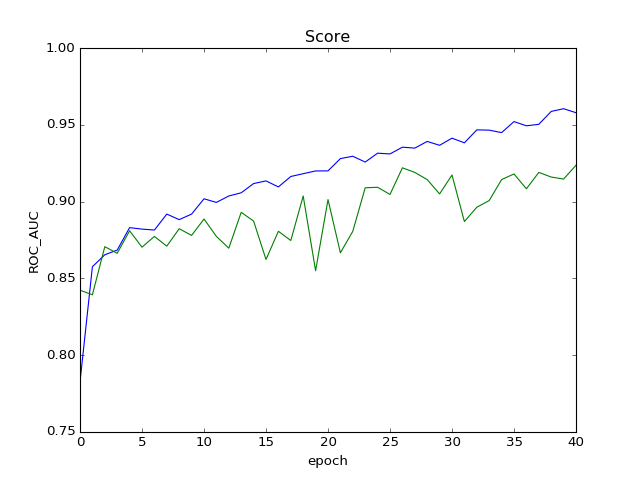

In [23]:
plt.title("Score")
plt.xlabel('epoch')
plt.ylabel('ROC_AUC')
plt.plot(train_curve)
plt.plot(test_curve)
plt.savefig('N4_600epoch.png')